In [2]:
!pip install pytorch-lightning

     |████████████████████████████████| 296kB 3.5MB/s 
     |████████████████████████████████| 276kB 10.9MB/s 
     |████████████████████████████████| 829kB 14.6MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=f1ced69654dab0f8d054318b06ace05281198b4fc5dab92e9d1391ed70df2895
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=fc322addff5b0f927232256ec42c23ff0ac92cff66debb7878c21103fc47f692
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [27]:
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import seed_everything

In [28]:
seed_everything(1)

transform_list = transforms.Compose([
            #transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
            #transforms.Normalize([0.5,],[0.5,])
        ])

class CNNModel(pl.LightningModule):
    def __init__(self):
        super(CNNModel, self).__init__()
        
         # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
         
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
      
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
         
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
         
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(64 * 5 * 5, 10) 
     
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x) 
        out = self.relu1(out) 
         
        # Max pool 1
        out = self.maxpool1(out)
         
        # Convolution 2 
        out = self.cnn2(out) 
        out = self.relu2(out) 
         
        # Max pool 2 
        out = self.maxpool2(out)
         

        out = out.view(out.size(0), -1)
 
        # Linear function (readout)
        out = self.fc1(out)
         
        return out

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'val_loss': F.cross_entropy(y_hat, y)}

    def validation_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'test_loss': F.cross_entropy(y_hat, y)}

    def test_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': logs, 'progress_bar': logs}
    
    def train_dataloader(self):
        # REQUIRED
        return DataLoader(CIFAR10(os.getcwd(), train=True, download=True, transform=transform_list), batch_size=128)

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(CIFAR10(os.getcwd(), train=True, download=True, transform=transform_list), batch_size=128)

    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(CIFAR10(os.getcwd(), train=False, download=True, transform=transform_list), batch_size=128)

In [29]:
if torch.cuda.is_available():
    gpus_value=1  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    gpus_value=0
    print("Running on the CPU")
    
input_dim = 32*32
hidden_dim = 200
output_dim = 10

model = CNNModel()
trainer = pl.Trainer(gpus = gpus_value, max_epochs=5)
trainer.fit(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | cnn1     | Conv2d    | 2 K   
1 | relu1    | ReLU      | 0     
2 | maxpool1 | MaxPool2d | 0     
3 | cnn2     | Conv2d    | 51 K  
4 | relu2    | ReLU      | 0     
5 | maxpool2 | MaxPool2d | 0     
6 | fc1      | Linear    | 16 K  


Running on the GPU
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified


1

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

# confusion matrix
cm = np.zeros((10,10), dtype=np.int)

labels_list = []
predicted_list = []

with torch.no_grad():     
    # Iterate through test dataset
    for images, labels in model.test_dataloader():
        images = images.cuda()
        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        #print(labels)
        #print(predicted)pre
        
        labels_list.extend(labels.tolist())
        predicted_list.extend(predicted.tolist())
        
cm += confusion_matrix(labels_list, predicted_list)

print(cm)

Files already downloaded and verified
[[681  32  41  50  19  20   9  12 114  22]
 [ 23 773   7  28   3   9  12   3  50  92]
 [ 79  12 388 125 106 152  62  41  24  11]
 [ 19  11  42 553  51 215  51  29  15  14]
 [ 34  10  66 107 523 101  47  94  15   3]
 [ 16   6  34 224  33 604  18  51   9   5]
 [  4  16  31 149  50  54 672   9   9   6]
 [ 24   3  22  72  56 128   7 673   4  11]
 [ 75  48  11  39   5  14   4   8 772  24]
 [ 43 161   9  36   7  21  12  22  62 627]]


Files already downloaded and verified
After 1st CNN layer


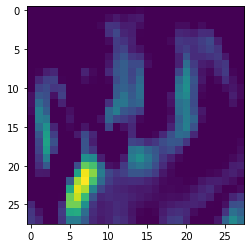

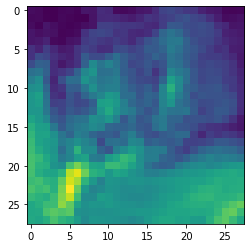

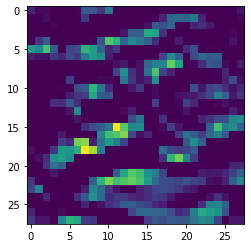

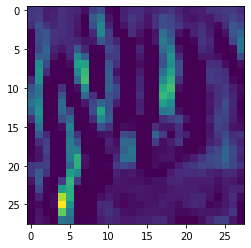

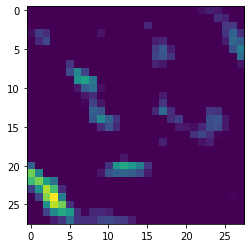

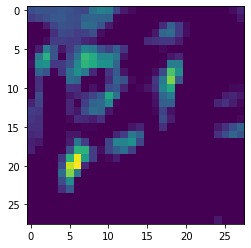

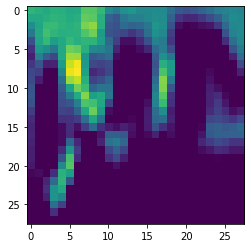

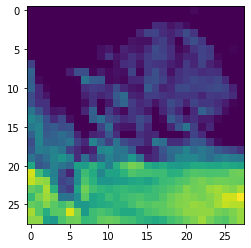

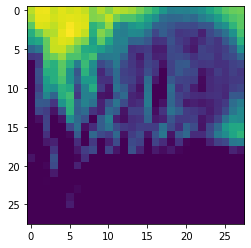

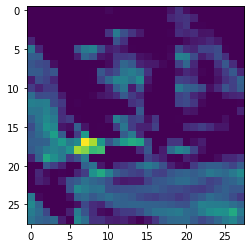

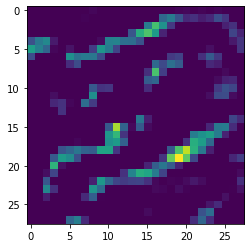

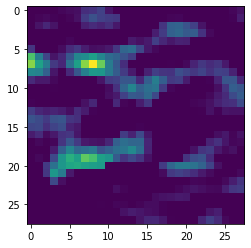

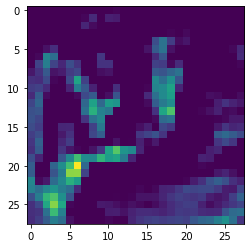

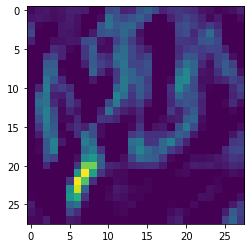

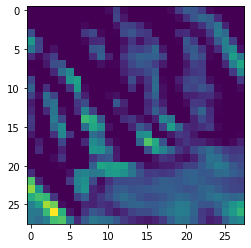

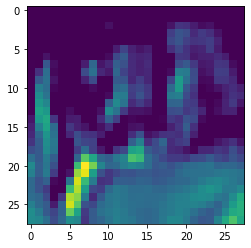

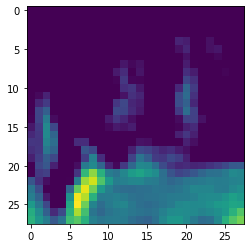

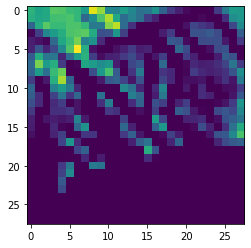

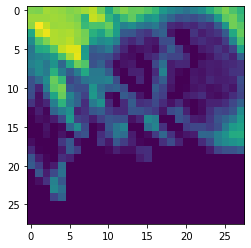

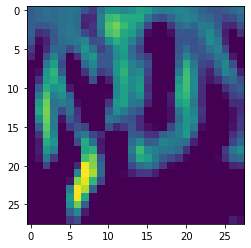

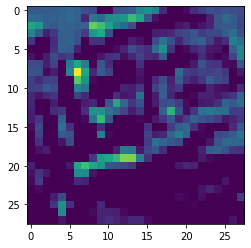

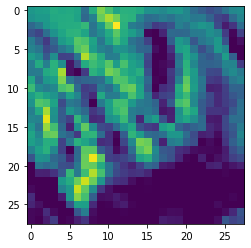

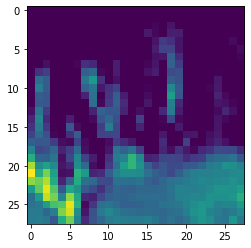

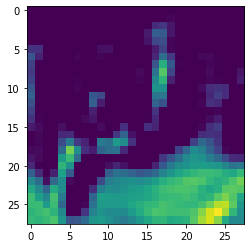

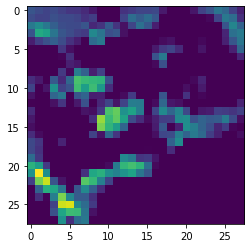

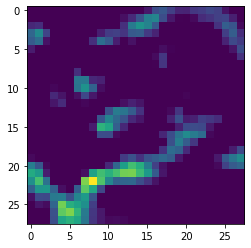

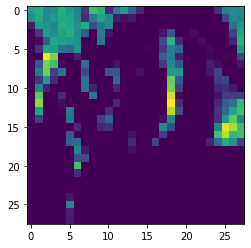

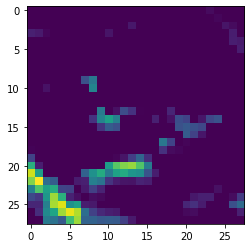

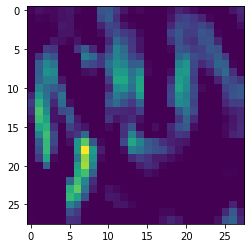

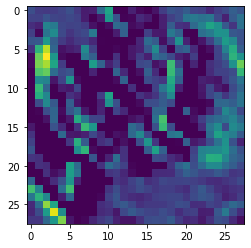

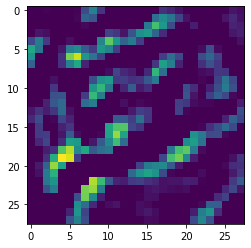

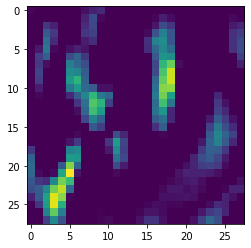

After 2nd CNN layer


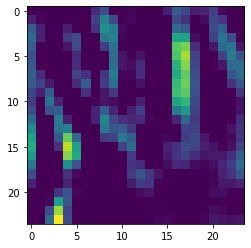

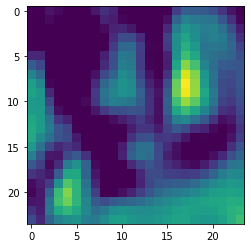

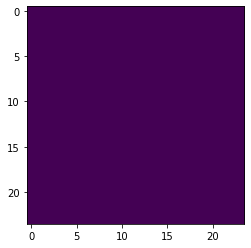

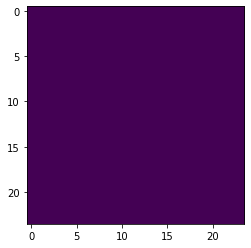

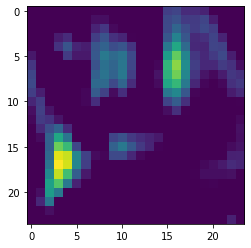

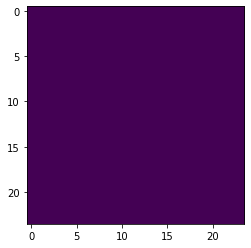

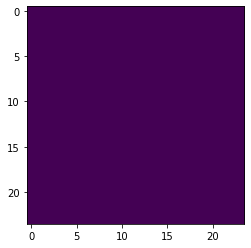

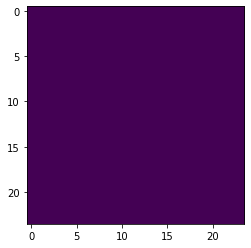

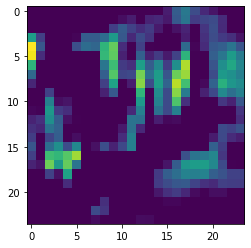

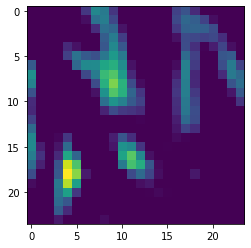

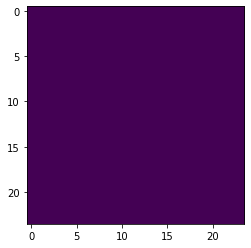

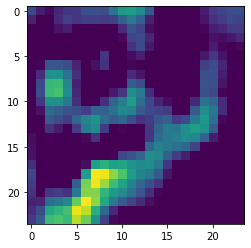

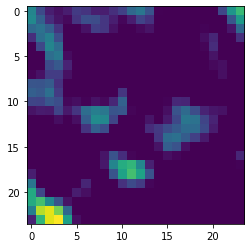

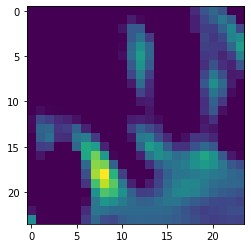

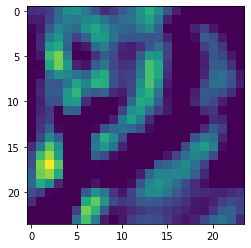

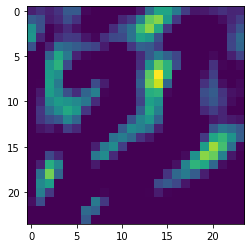

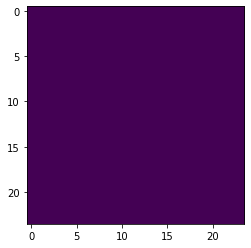

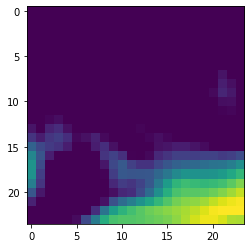

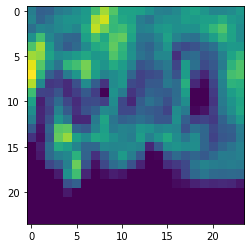

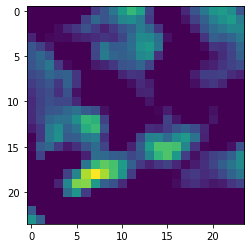

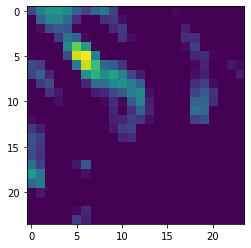

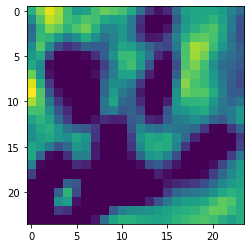

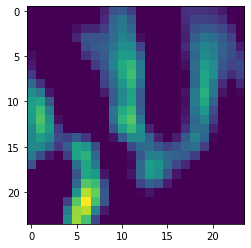

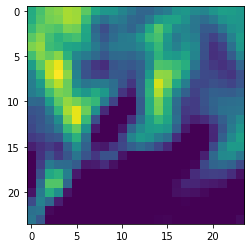

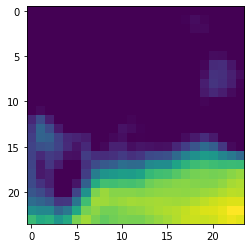

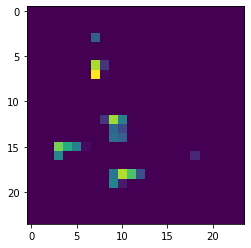

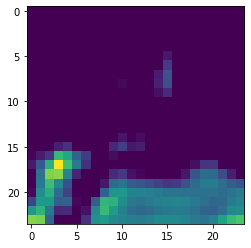

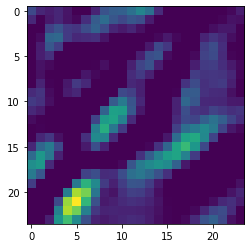

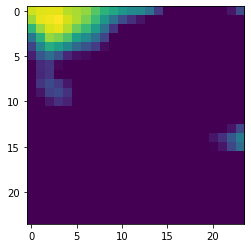

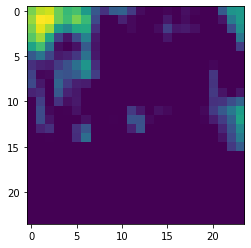

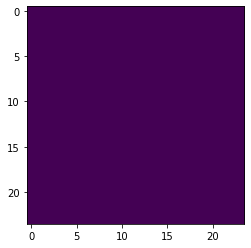

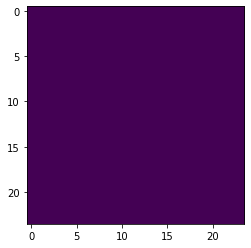

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

for images, labels in model.test_dataloader():
    images = images.cuda()
    
    out = model.cnn1(images)
    out = model.relu1(out)
    out_cpu = torch.FloatTensor(out[0].cpu().detach().numpy())
    print('After 1st CNN layer')
    for i in range(32):
      plt.imshow(out_cpu[i])
      plt.show()
        
    # Convolution 2 
    out = model.cnn2(out) 
    out = model.relu2(out)
    out_cpu = torch.FloatTensor(out[0].cpu().detach().numpy())
    print('After 2nd CNN layer')
    for i in range(32):
      plt.imshow(out_cpu[i])
      plt.show()

    break

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/